In [2]:
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, LearningCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import sparse

seed = 1234
np.random.seed(seed)

In [7]:
def load_imdb_dataset(get_vectorizer=False):
    dataset = load_dataset("imdb").shuffle(seed=seed)
    vectorizer = TfidfVectorizer().fit(dataset["train"]["text"])

    train_texts = vectorizer.transform(dataset["train"]["text"])
    train_labels = np.array(dataset["train"]["label"])

    test_texts = vectorizer.transform(dataset["test"]["text"])
    test_labels = np.array(dataset["test"]["label"])

    del dataset
    if not get_vectorizer:
        del vectorizer

    train_texts, valid_texts, train_labels, valid_labels = train_test_split(
        train_texts,
        train_labels,
        test_size=0.25,
        random_state=seed,
        stratify=train_labels
    )

    return (
        train_texts,
        train_labels,
        valid_texts,
        valid_labels,
        test_texts,
        test_labels
    ) if not get_vectorizer else (
        train_texts,
        train_labels,
        valid_texts,
        valid_labels,
        test_texts,
        test_labels,
        vectorizer
    )

In [8]:
train_X, train_y, valid_X, valid_y, test_X, test_y = load_imdb_dataset()

In [4]:
# Define parameter grid for grid search
params = [
    {
        'solver': ['lbfgs'],
        'penalty': ['l2', 'none'], 
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 200, 500]
    },

    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'], 
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 200, 500] 
    },
    {
        'solver': ['newton-cg'],
        'penalty': ['l2', 'none'], 
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 200, 500]
    },
    {
        'solver': ['sag'],
        'penalty': ['l2', 'none'], 
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 200, 500]
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'none'], 
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 200, 500]
    },
    {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': [0.25, 0.5, 0.75], 
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 200, 500]
    }
]

In [ ]:
# Perform a grid search over the specified hyperparameters
# Warning: Grid search is exhaustive, takes a considerable amount of time

X_combined = sparse.vstack([train_X, valid_X])
y_combined = np.concatenate([train_y, valid_y])

test_fold = np.zeros(train_y.shape[0] + valid_y.shape[0])
test_fold[:train_y.shape[0]] = -1

lr = LogisticRegression(random_state=seed)
clf = GridSearchCV(lr, params, cv=PredefinedSplit(test_fold), n_jobs=-1, verbose=1)
clf.fit(X_combined, y_combined)

In [ ]:
# Evaluate the best estimator as determined through the grid search
print(clf.best_estimator_.get_params())
print(f'Grid Search Logistic Regression Validation Error: {(1 - clf.best_score_) * 100:.2f}%')
print(f'Grid Search Logistic Regression Test Error: {(1 - clf.best_estimator_.score(test_X, test_y)) * 100:.2f}%')

{'C': 10.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 1234, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Grid Search Logistic Regression Validation Error: 11.07%
Grid Search Logistic Regression Test Error: 11.91%


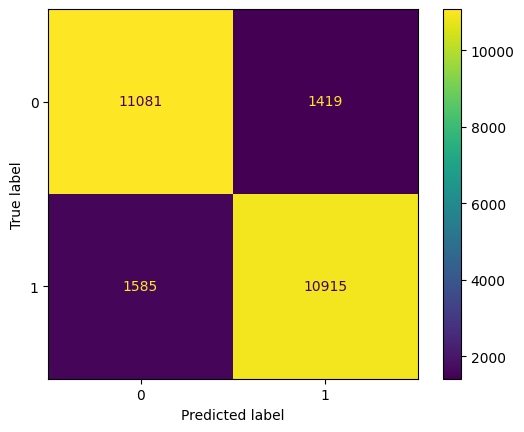

In [9]:
# Visualize a confusion matrix for the best logistic regression model we found

# best_lr = clf.best_estimator_.get_params()
best_lr = LogisticRegression(penalty = 'l2', C=10.0, max_iter=100, random_state=seed, solver='lbfgs').fit(train_X, train_y)
cf_display = ConfusionMatrixDisplay.from_estimator(best_lr, test_X, test_y)

Text(0.5, 1.0, 'Learning Curve for Logistic Regression Classifier')

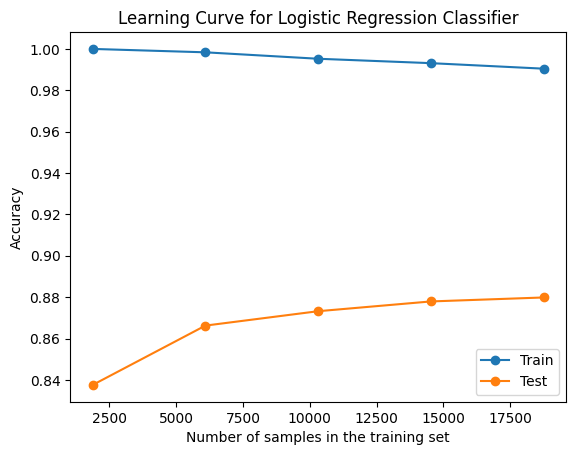

In [10]:
X_combined = sparse.vstack([train_X, test_X])
y_combined = np.concatenate([train_y, test_y])

test_fold = np.zeros(train_y.shape[0] + test_y.shape[0])
test_fold[:train_y.shape[0]] = -1

common_params = {
    "X": X_combined,
    "y": y_combined,
    "cv": PredefinedSplit(test_fold),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(best_lr, **common_params).ax_.set_title("Learning Curve for Logistic Regression Classifier")